In [ ]:
suppressPackageStartupMessages(library(dplyr)) 
library(ggplot2)
# library(caret)
library(pheatmap)
library(RColorBrewer)
library(Seurat)
library(Signac)
library(harmony)
# library("monocle3", lib.loc = "/projects/ps-renlab/y2xie/anaconda3/envs/seurat/lib/R//library/monocle3/")
source("/projects/ps-renlab/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")
suppressPackageStartupMessages(library("EnsDb.Hsapiens.v75"))

In [ ]:
path <- '/projects/ps-renlab2/y2xie/projects/77.LC/39.Paired_HiC_NovaSeq_230125'
subdir <- "230320"

# Manual cell filtering

In [45]:
translation <- read.table("/projects/ps-renlab/y2xie/projects/genome_ref/arc_bc-translation.txt", header = T)
translation$atac <- paste0(translation$atac, "-1")
translation$rna <- paste0(translation$rna, "-1")

In [46]:
### remember to softlink RNA
dna <- c("LC252", "LC253", "LC378", "LC409", "LC411", "LC464", "LC465", "LC608", "LC609")
rna <- c("LC254", "LC255", "LC380", "LC410", "LC412", "LC466", "LC467", "LC613", "LC614")
path1 <- "/projects/ps-renlab/y2xie/projects/Paired-Tag/77.LC_Paired-Tag/18.Paired_HiC_mouse_cortex/03.mapping/merged_all_pair/"
path2 <- "/projects/ps-renlab/y2xie/projects/Paired-Tag/77.LC_Paired-Tag/26.Paired_HiC_mouse_cortex_inhouseTn5/"
path3 <- "/projects/ps-renlab/y2xie/projects/Paired-Tag/77.LC_Paired-Tag/29.Paired_HiC_mouse_cortex_221018/"
path4 <- "/projects/ps-renlab2/y2xie/projects/77.LC/39.Paired_HiC_NovaSeq_230125/"
path5 <- "/projects/ps-renlab2/y2xie/projects/77.LC/46.Paired-HiC_MouseCortex_NovaSeq_220417/"
path6 <- "/projects/ps-renlab2/y2xie/projects/77.LC/38.Paired-HiC_MouseCortex/"
rpath <- c(path1, path1, path2, path3, path3, path6, path6, path5, path5)

dpath <- c(paste0(path1, "LC252_mm10.sc.stat.csv"), 
           paste0(path1, "LC253_mm10.sc.stat.csv"), 
           paste0(path2, "03.mapping/221009/LC378_merge_mm10.sc.stat.csv"), 
           paste0(path3, "03.mapping/LC409_mm10.sc.stat.csv"), 
           paste0(path3, "03.mapping/LC411_mm10.sc.stat.csv"), ### LC411: /projects/ps-renlab2/y2xie/projects/77.LC/33.Paired_HiC_NovaSeq_221206/03.mapping/LC411_merged_mm10.sc.pairs.gz
           paste0(path4, "03.mapping/LC464_merged_mm10.sc.stat.csv"), 
           paste0(path4, "03.mapping/LC465_mm10.PairCount.stat.csv"),
           paste0(path5, "03.mapping/LC608_mm10.sc.stat.csv"),
           paste0(path5, "03.mapping/LC609_mm10.sc.stat.csv"))

meta <- data.frame(dna = dna,
                   rna = rna,
                   rpath = rpath,
                   dmeta = dpath)

In [66]:
dcutoff <- c(500, 400, 300, 1000, 1000, 2000, 2000, 2000, 1000)
rcutoff <- c(700, 600, 500, 1000, 600, 500, 500, 500, 600)

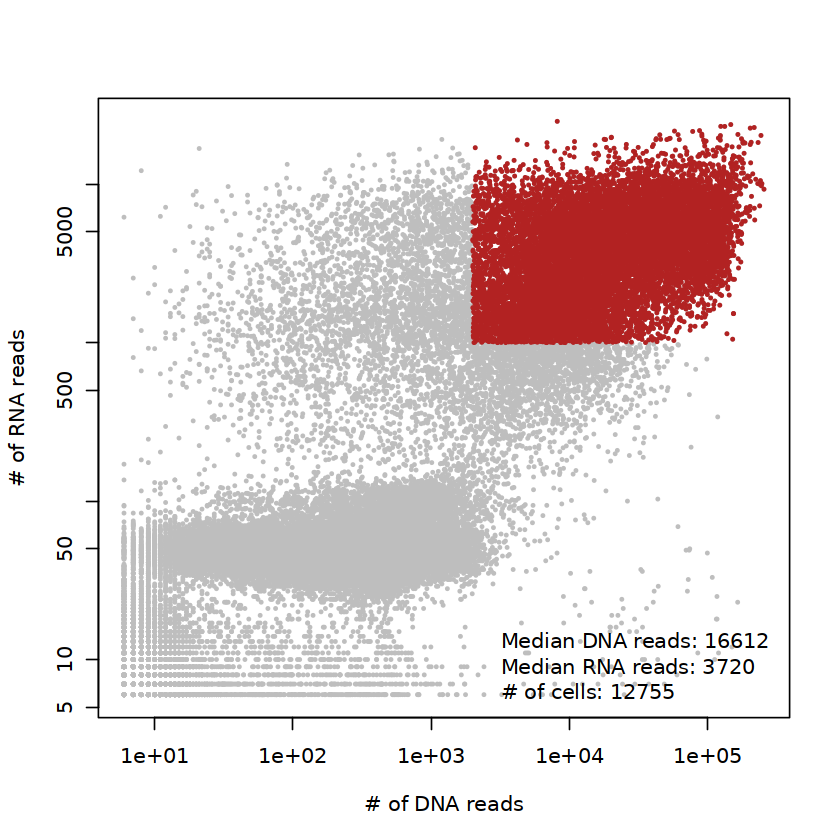

In [55]:
i = 8
pair <- plotPair(RNA = paste0(rpath[i], "/", rna[i], "/outs/raw_feature_bc_matrix/"),
                 DNA = dpath[i],
                 dna.cutoff = 2000,
                 rna.cutoff = 1000)

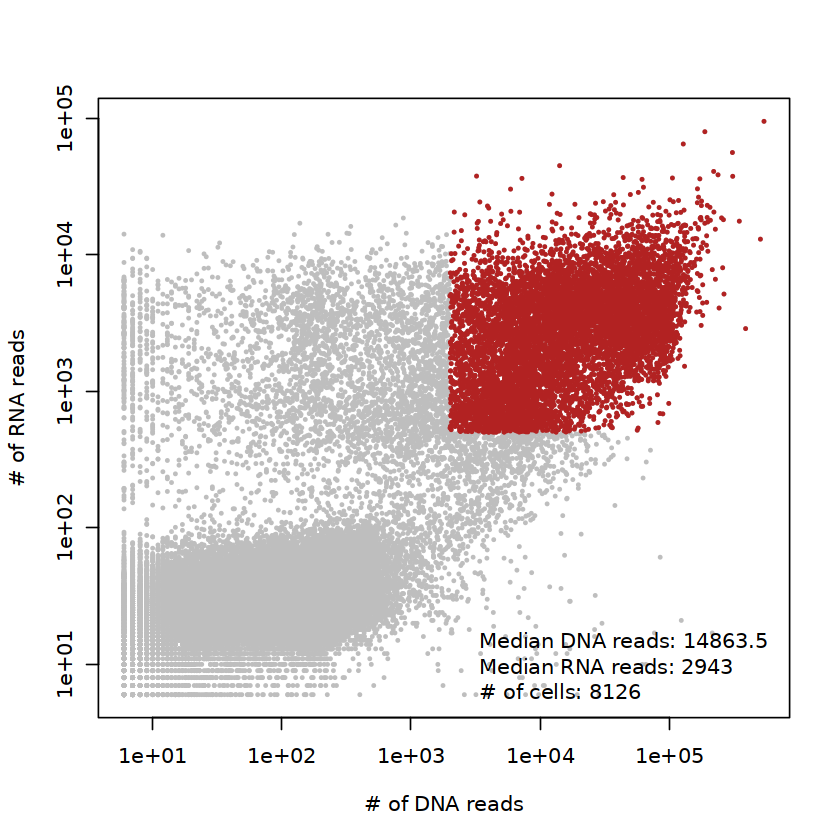

In [67]:
### Segment for all
for (i in 6:8){
    pair <- plotPair(RNA = paste0(rpath[i], "/", rna[i], "/outs/raw_feature_bc_matrix/"),
                     DNA = dpath[i],
                     dna.cutoff = dcutoff[i],
                     rna.cutoff = rcutoff[i])
    write.table(paste0(translation[translation$name %in% pair$Row.names,]$rna), 
            file = paste0("PF_cells/", dna[i], "_", rna[i], "_rna.bc.txt"), sep = "\t", row.names = F, col.names = F, quote = F)
    write.table(paste0(translation[translation$name %in% pair$Row.names,]$atac), 
            file = paste0("PF_cells/", dna[i], "_", rna[i], "_atac.bc.txt"), sep = "\t", row.names = F, col.names = F, quote = F)
}

## RNA clustering of all cells?

In [149]:
tmeta <- mmg@meta.data[,c(1:13,16,19:20,22:50)] 
write.table(tmeta, "Paired_Hi-C_mouse_ctx_metadata.xls", sep = "\t", quote = F, row.names = T, col.names = T)

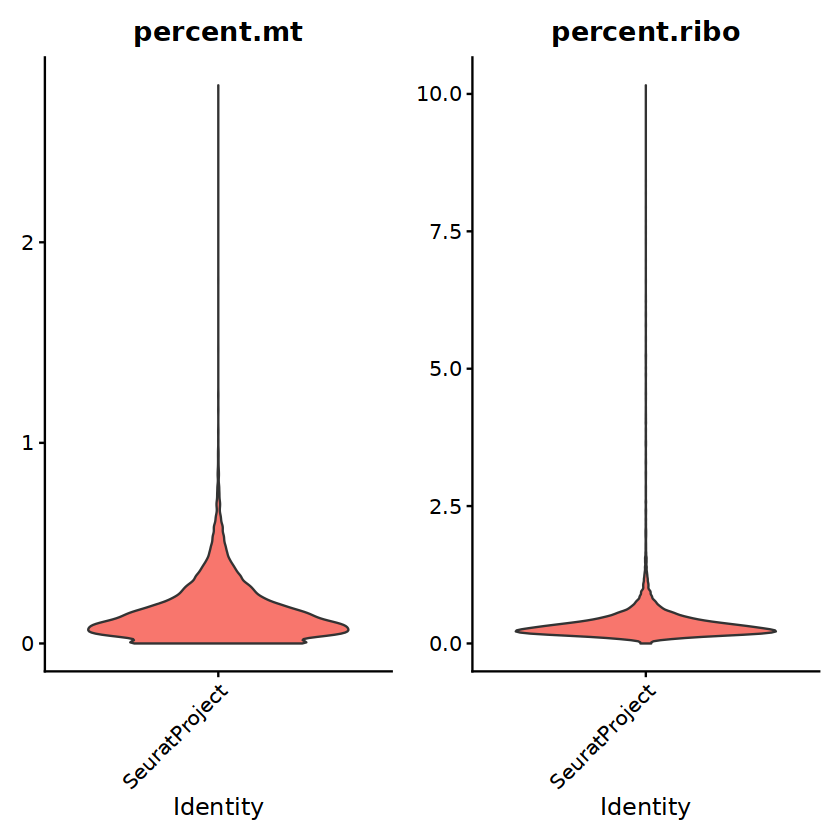

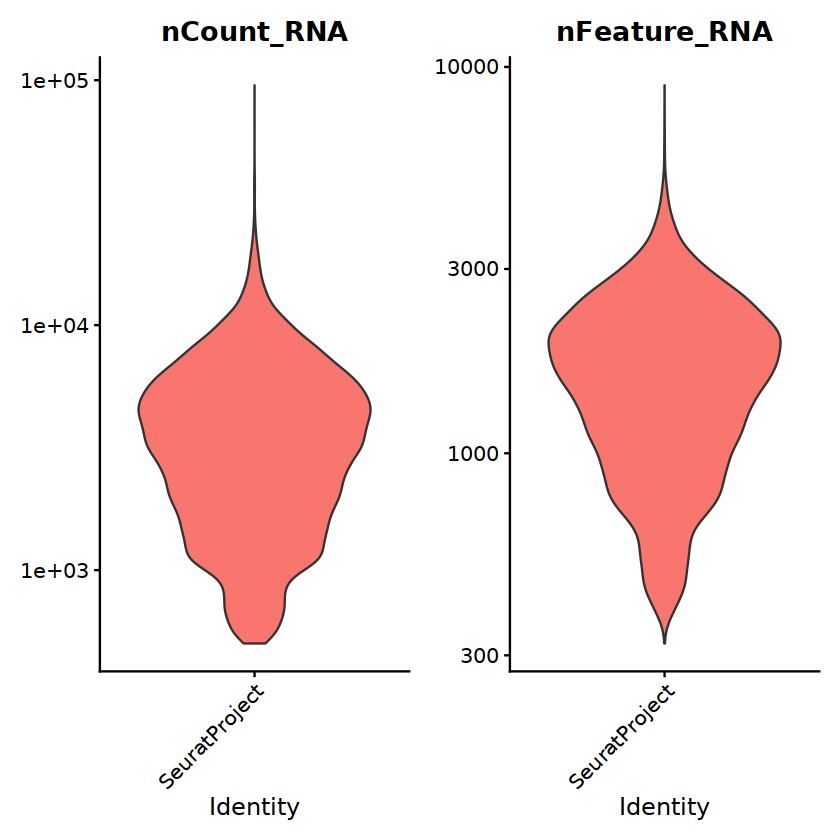

In [73]:
### only do selected groups

mtx_list <- list()
for (i in 6:8){
    f <- rna[i]
    counts <- Read10X(paste0(rpath[i], f, "/outs/raw_feature_bc_matrix"))
    cells <- read.table(paste0("PF_cells/", dna[i], "_", rna[i], "_rna.bc.txt"))
    cells$V1 <- paste0(cells$V1, "-1")
    cells$V1 <- substr(cells$V1, 1, 18)
    counts <- counts[, cells$V1]
    colnames(counts) <- paste0(f, ":", colnames(counts))
    mtx_list[[f]] <- counts
}

mtx <- Reduce(cbind, mtx_list[-1], mtx_list[[1]]) # dont use do.call for cbind
mmg <- CreateSeuratObject(mtx)

mmg$bc <- gsub("^([^:]+):(.*)$", "\\2", colnames(mmg))

translation <- read.table("/projects/ps-renlab/y2xie/projects/genome_ref/arc_bc-translation.txt", header = T)
mmg$atac_bc <- translation[match(mmg$bc, paste0(translation$rna, "-1")), ]$atac
mmg$rna <- gsub("^([^:]+):(.*)$", "\\1", colnames(mmg))
mmg$dna <- meta[match(mmg$rna, meta$rna), ]$dna
mmg$percent.mt <- PercentageFeatureSet(mmg, pattern = "^mt-")
mmg$percent.ribo <- PercentageFeatureSet(mmg, pattern = "(^Rpl|^Rps|^Mrp)")

gene_lcf <- median(log10(mmg$nFeature_RNA)) - 3*mad(log10(mmg$nFeature_RNA))
gene_hcf <- median(log10(mmg$nFeature_RNA)) + 3*mad(log10(mmg$nFeature_RNA))
count_hcf <- median(log10(mmg$nCount_RNA)) + 3*mad(log10(mmg$nCount_RNA))

VlnPlot(mmg, features = c("percent.mt", "percent.ribo"), pt.size = 0)
VlnPlot(mmg, features = c("nCount_RNA", "nFeature_RNA"), log = T, pt.size = 0)

In [113]:
system("mkdir scrublet")
for (i in 6:8){
    f <- rna[i]
    system(paste0("python /projects/ps-renlab2/y2xie/scripts/Paired-Tag/RunScrublet.py --input ", "scrublet/", rna, "_PF_cells.mtx ", 
              "--cells ", "scrublet/", rna, "_PF_cells.txt ", 
              "--output ", "scrublet/", rna))
}

In [87]:
### Automatically define cutoff
library(mixtools)
find.cutoff <- function(model, proba=0.5, i=index.lower) {
    ## Cutoff such that Pr[drawn from bad component] == proba
    f <- function(x) {
        proba - (model$lambda[i]*dnorm(x, model$mu[i], model$sigma[i]) /
                     (model$lambda[1]*dnorm(x, model$mu[1], model$sigma[1]) + model$lambda[2]*dnorm(x, model$mu[2], model$sigma[2])))
        }
        return(uniroot(f=f, lower=0.2, upper=1)$root)  # Careful with division by zero if changing lower and upper
}

number of iterations= 214 


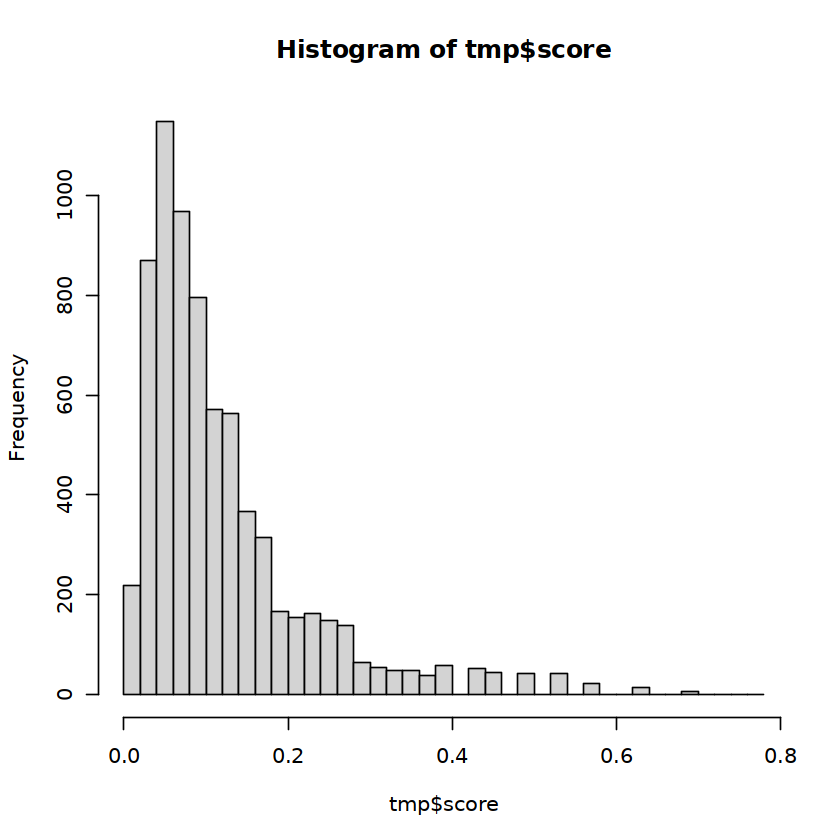

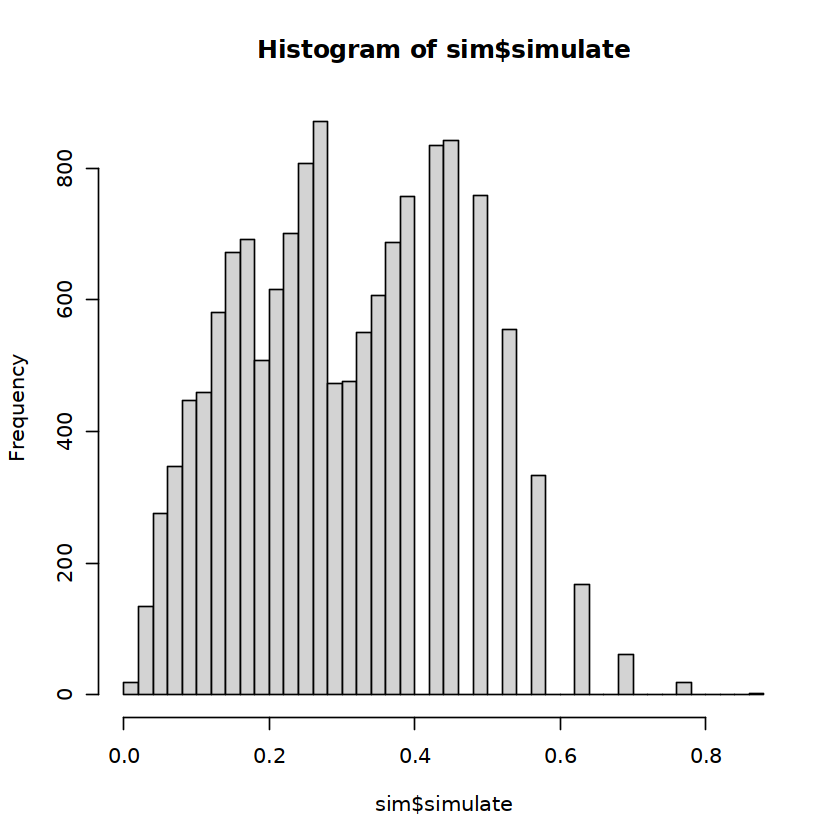

WARNING! NOT CONVERGENT! 
number of iterations= 1000 


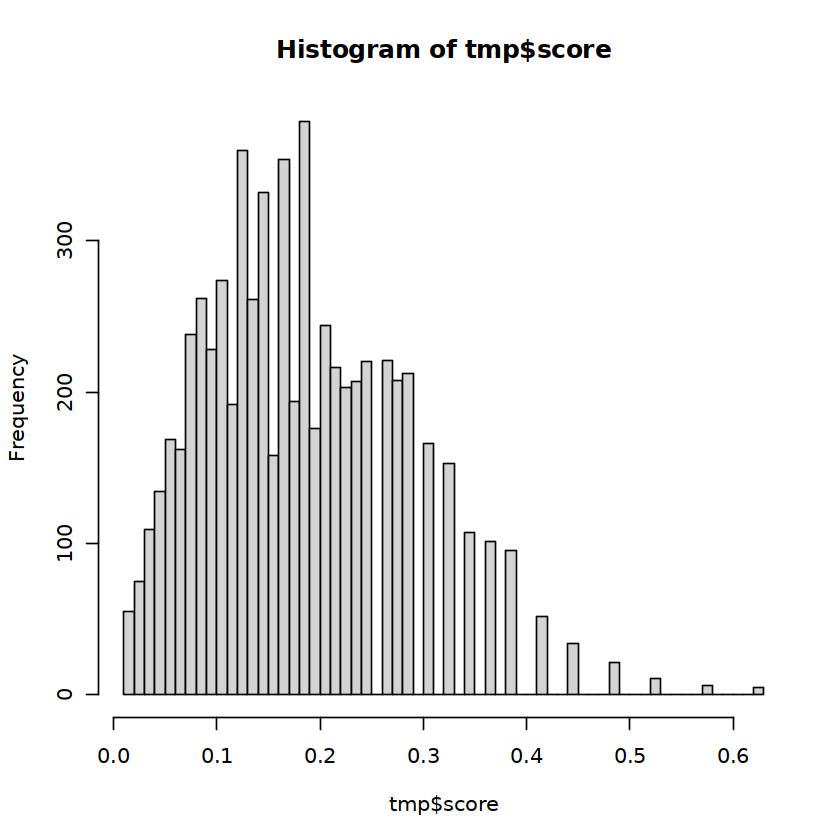

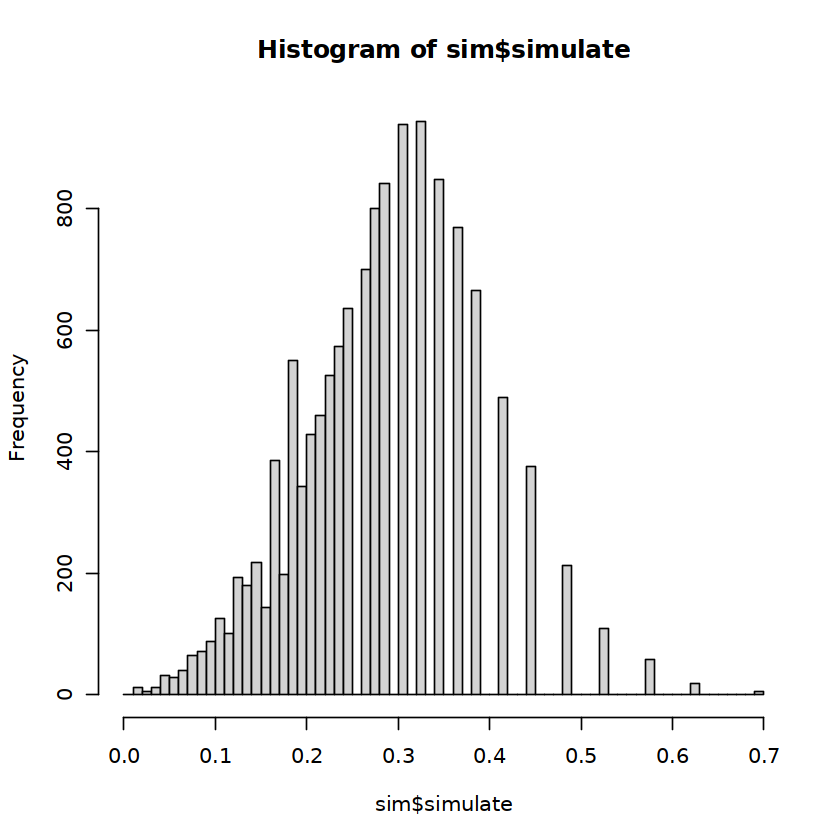

number of iterations= 914 


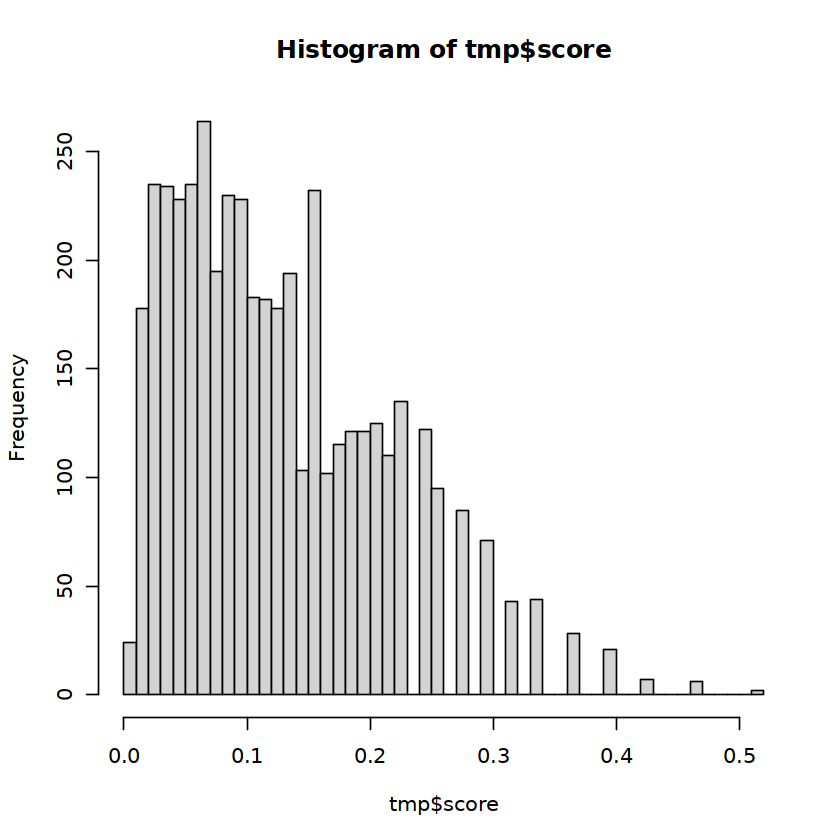

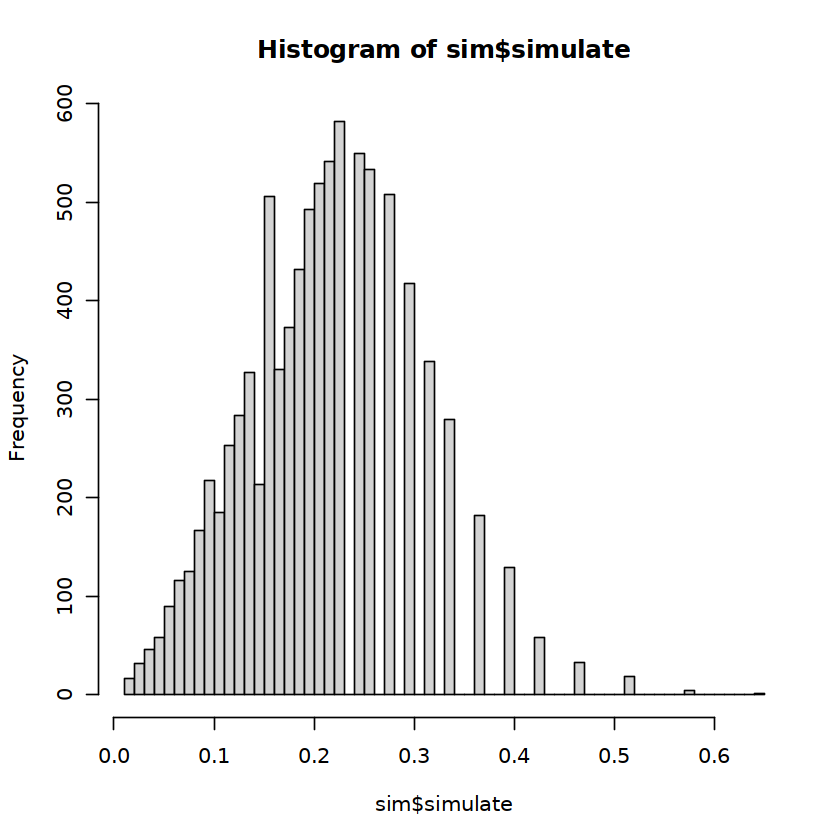

number of iterations= 598 


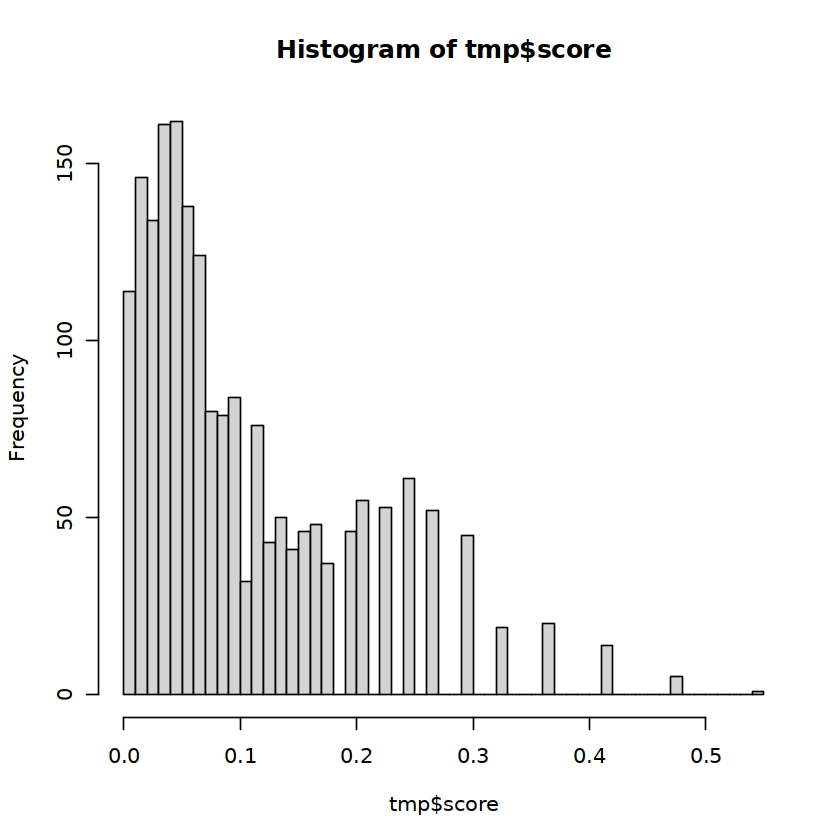

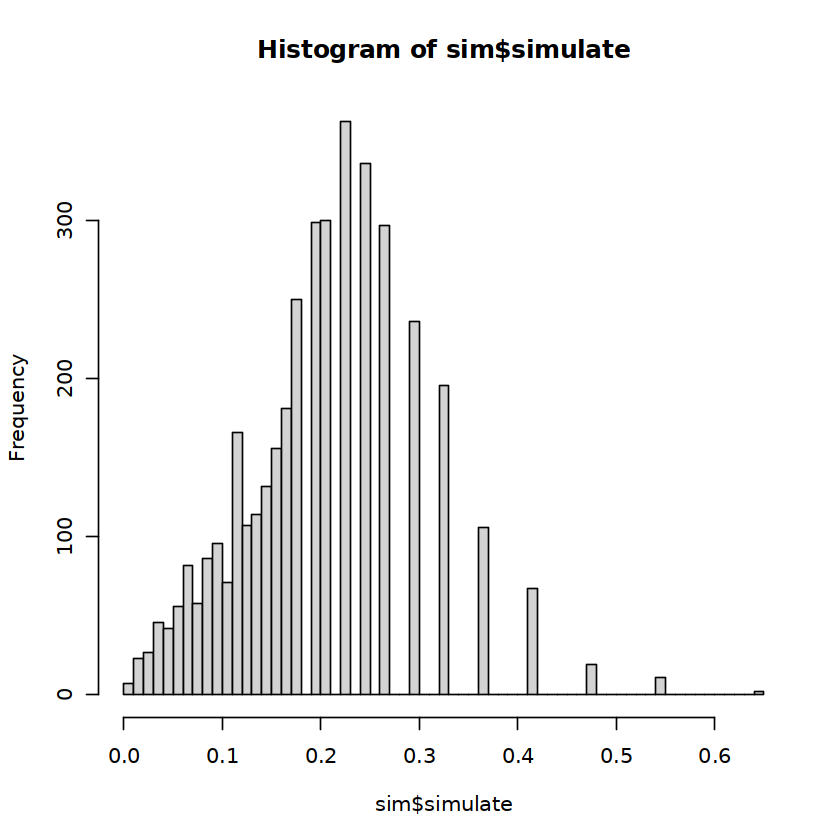

number of iterations= 629 


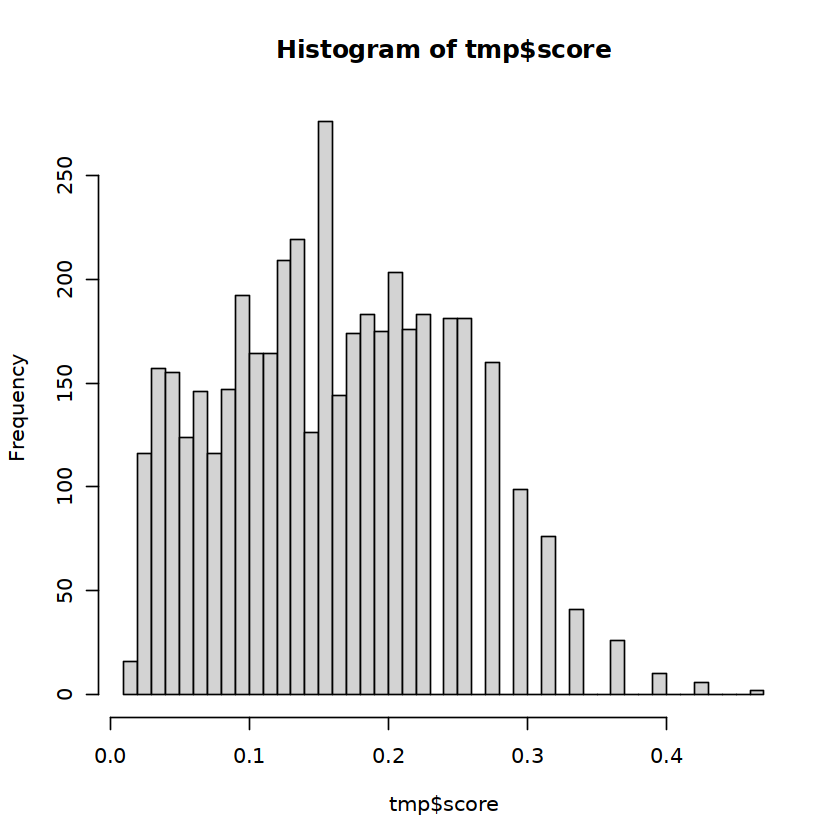

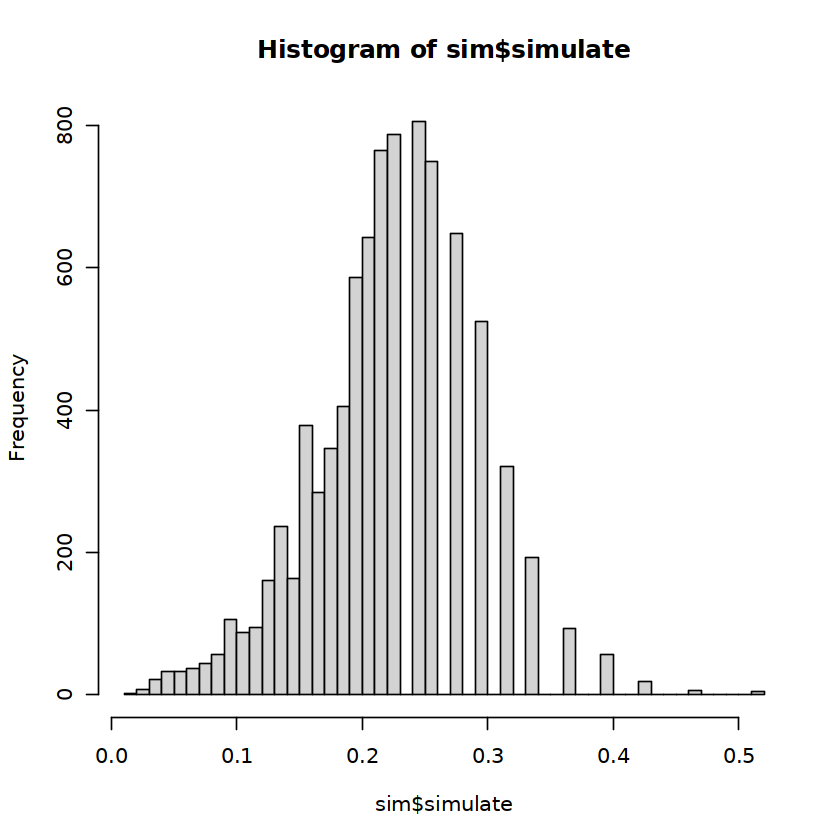

number of iterations= 143 


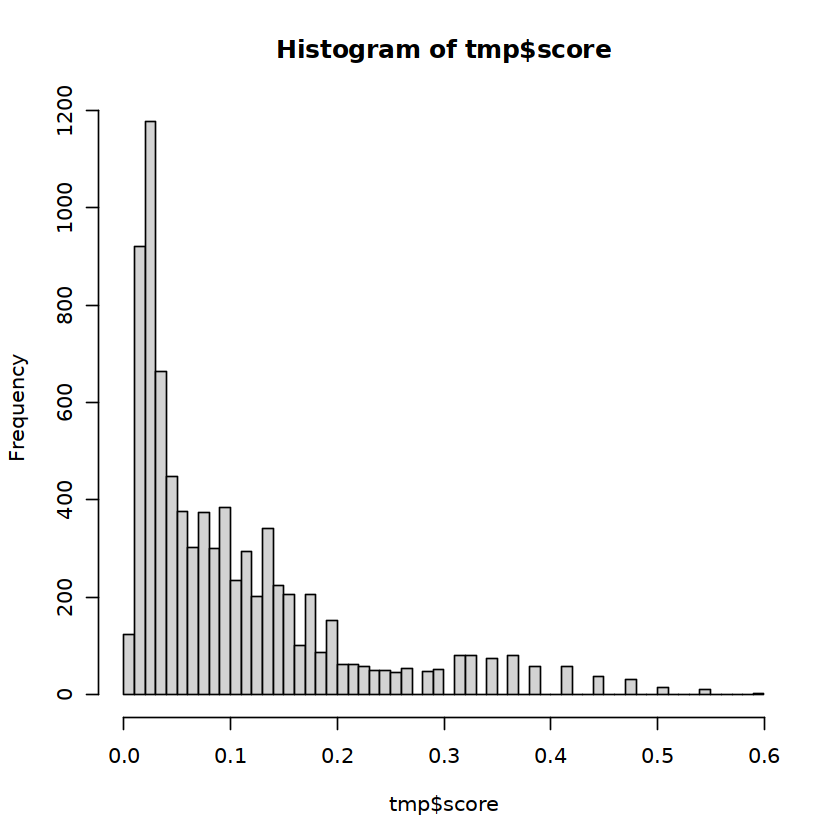

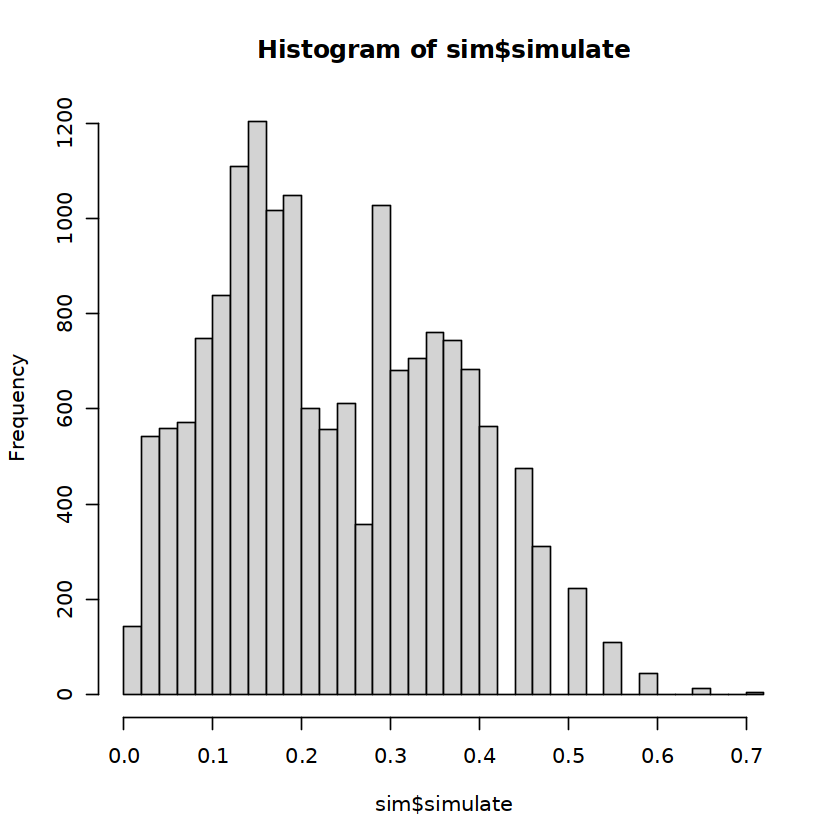

number of iterations= 71 


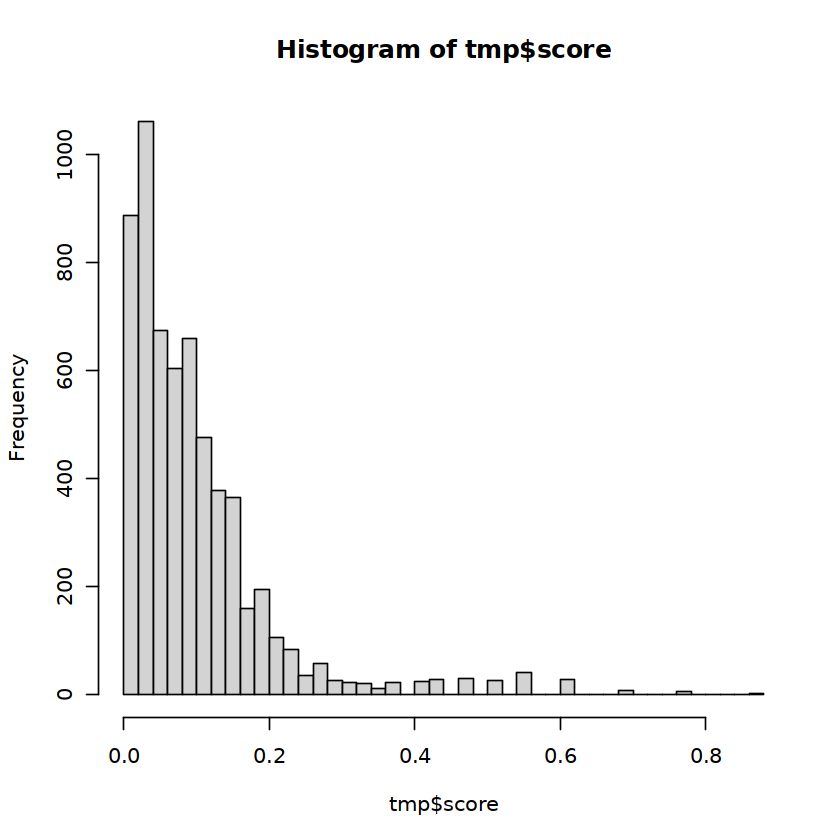

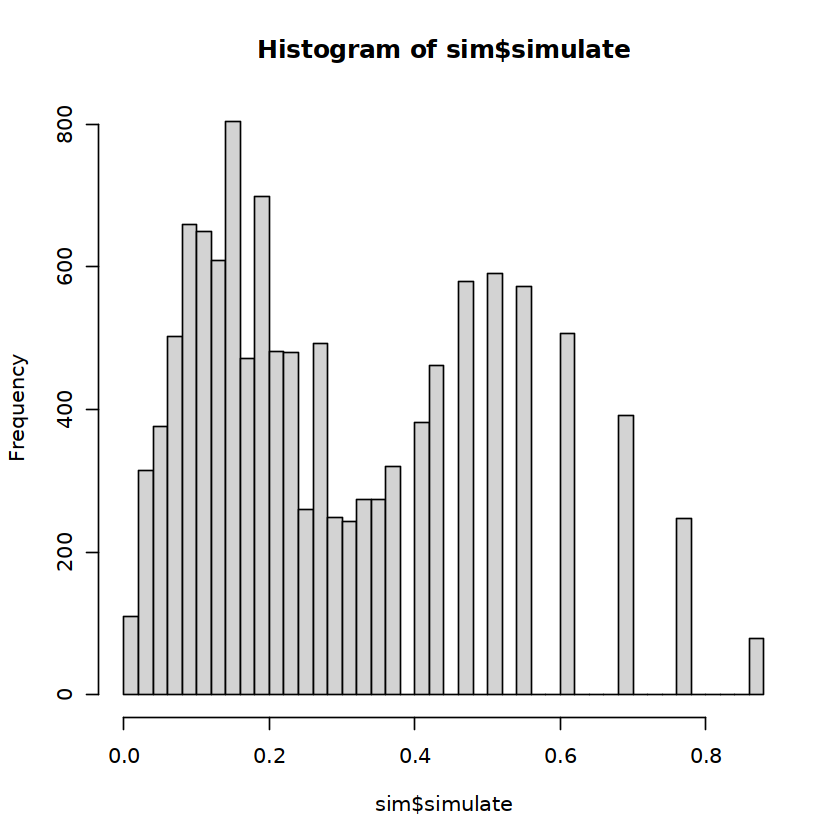

number of iterations= 159 


Warning message in int_abline(a = a, b = b, h = h, v = v, untf = untf, ...):
"NAs introduced by coercion"
Warning message in int_abline(a = a, b = b, h = h, v = v, untf = untf, ...):
"NAs introduced by coercion"


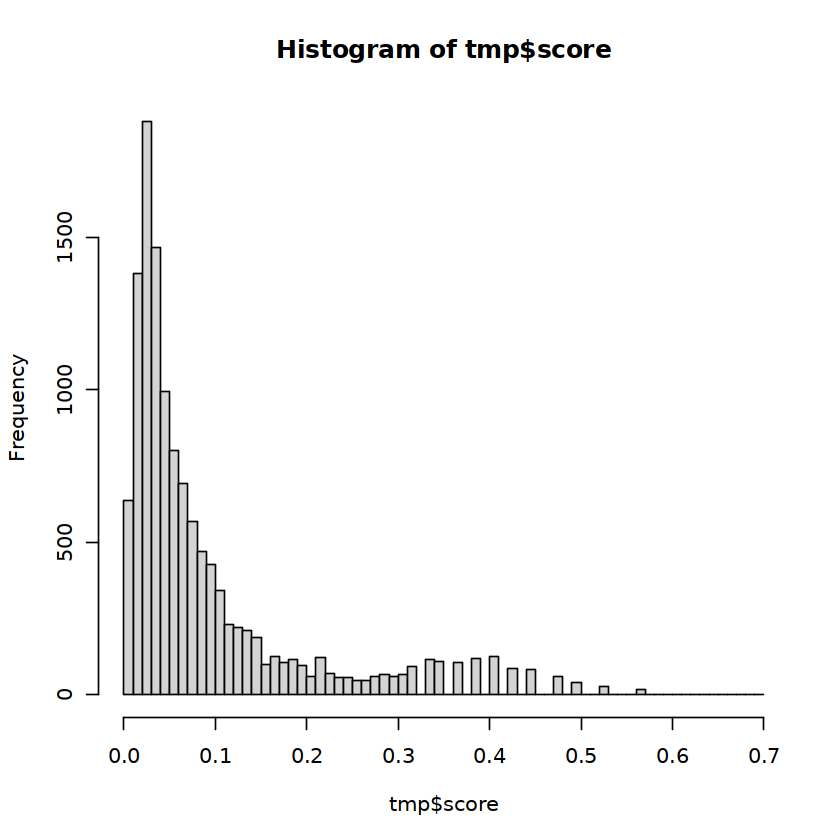

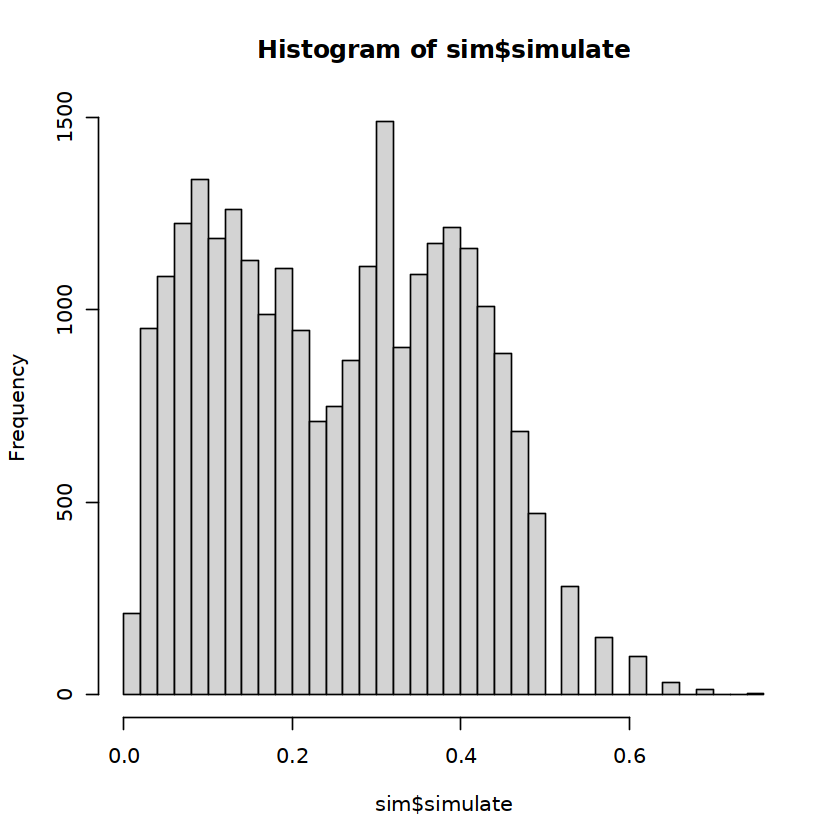

number of iterations= 173 


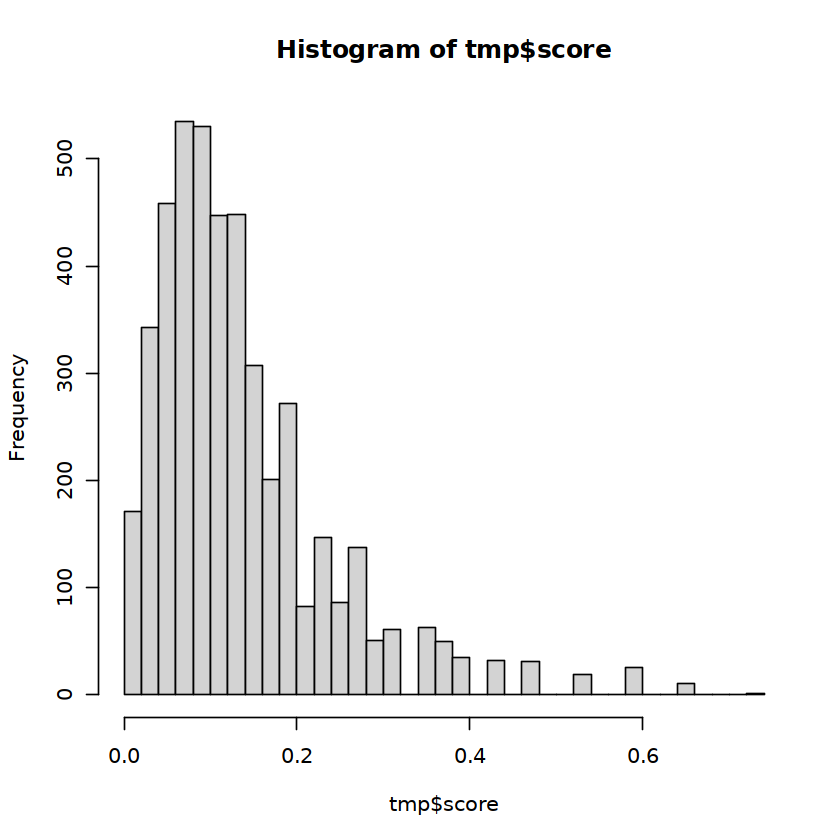

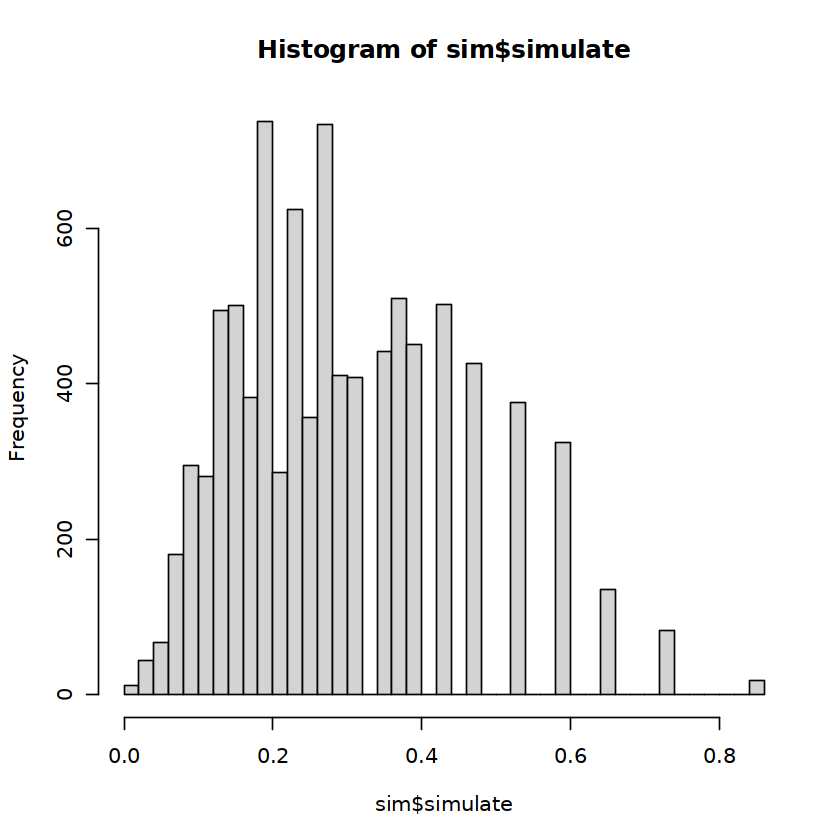

In [114]:
doublet_list <- list()
i = 1

for (f in list.files(path = "scrublet/", pattern = ".*_scrublet.csv$")){
    fname <- sub("_scrublet.csv", "", f)
    tmp <- read.csv(paste0("scrublet/", fname, "_scrublet.csv"))
    rownames(tmp) <- tmp$id
    sim <- read.csv(paste0("scrublet/", fname, "_scrublet_simulate.csv"))
    doublet_scores_obs.hist <- hist(tmp$score, breaks = 50)
    doublet_scores_sim.hist <- hist(sim$simulate, breaks = 50)
    
    ### Model
    mixmdl = normalmixEM(sim$simulate[is.finite(sim$simulate)], k = 2)
    dist1.lambda <- mixmdl$lambda[1]
    dist2.lambda <- mixmdl$lambda[2]
    dist1.mu <- mixmdl$mu[1]
    dist1.sigma <- mixmdl$sigma[1]
    dist2.mu <- mixmdl$mu[2]
    dist2.sigma <- mixmdl$sigma[2]
    
    ### Find cutoff
    index.lower <- which.min(mixmdl$mu)
    t <- try(find.cutoff(mixmdl, proba=0.5), silent=TRUE)
    if("try-error" %in% class(t)){
        cutoffs <- 0.25 ### default
    }else{
        cutoffs <- find.cutoff(mixmdl, proba=0.5)
    }
    
    ### Plot
    pdf(paste0("scrublet/", fname, ".fitHistDoublets.pdf"), height=6, width=8)
    par(mfrow=c(2,2));
    plot(doublet_scores_obs.hist, xlim = c(0,1), col="grey", border = "grey", main = "Observed profiles", xlab = "Doublet score", ylab = "Prob. density (log10)")
    abline(v = t, col = "black")

    plot(doublet_scores_sim.hist, xlim = c(0,1), col="grey", border = "grey", main = "Simulated doublets", xlab = "Doublet score", ylab = "Prob. density")
    abline(v = t, col = "black")

    plot(mixmdl,which=2)

    plot(doublet_scores_sim.hist, xlim = c(0,1), col="grey", border = "grey", main = "Simulated doublets", xlab = "Doublet score", ylab = "Prob. density")
    abline(v=cutoffs, col=c("red", "blue"), lty=2)

    dev.off()
    
    ### assign
    rownames(tmp) <- paste0(rownames(tmp), "-1")
    rownames(tmp) <- substr(rownames(tmp), 1, 18)
    rownames(tmp) <- paste0(fname, ":", rownames(tmp))
    tmp$manual <- "False"
    tmp[tmp$score > cutoffs, ]$manual <- "True"
    
    doublet_list[[i]] <- tmp
    i = i + 1
}

In [115]:
doublet_list <- do.call(rbind, doublet_list)
# rownames(doublet_list) <- substr(rownames(doublet_list), 1, 24)

ncol(mmg)
intersect(colnames(mmg), rownames(doublet_list)) %>% length

[1] 26920

[1] 26920

In [116]:
mmg$scrublet_score <- doublet_list[colnames(mmg),]$score
mmg$scrublet_ident <- doublet_list[colnames(mmg),]$manual

In [117]:
saveRDS(mmg, "seurat_object/FC_phc_RNA_230728_all.rds")

## Only keep PF data

In [3]:
mmg
mmg <- subset(mmg, subset = dna %in% c("LC464", "LC465", "LC608"))
mmg

An object of class Seurat 
32285 features across 53908 samples within 1 assay 
Active assay: RNA (32285 features, 0 variable features)

An object of class Seurat 
32285 features across 24687 samples within 1 assay 
Active assay: RNA (32285 features, 0 variable features)

In [11]:
mmg@meta.data %>%
dim

mmg@meta.data %>%
dplyr::filter(total > 30000) %>%
dim

[1] 24284    28

[1] 8363   28

In [102]:
mmg
gene_lcf <- median(log10(mmg$nFeature_RNA)) - 3*mad(log10(mmg$nFeature_RNA))
gene_hcf <- median(log10(mmg$nFeature_RNA)) + 3*mad(log10(mmg$nFeature_RNA))
count_hcf <- median(log10(mmg$nCount_RNA)) + 3*mad(log10(mmg$nCount_RNA))
### we dont need to filter based on reads and features anymore

upcut <- quantile(mmg$nCount_RNA, probs = 0.99)
upcut2 <- quantile(mmg$nFeature_RNA, probs = 0.99)
mmg <- subset(mmg, subset = scrublet_ident == "False" & nCount_RNA < 10^count_hcf & nFeature_RNA < 10^gene_hcf & percent.mt < 5 & percent.ribo < 10)
mmg

An object of class Seurat 
32285 features across 26920 samples within 1 assay 
Active assay: RNA (32285 features, 0 variable features)

An object of class Seurat 
32285 features across 24284 samples within 1 assay 
Active assay: RNA (32285 features, 0 variable features)

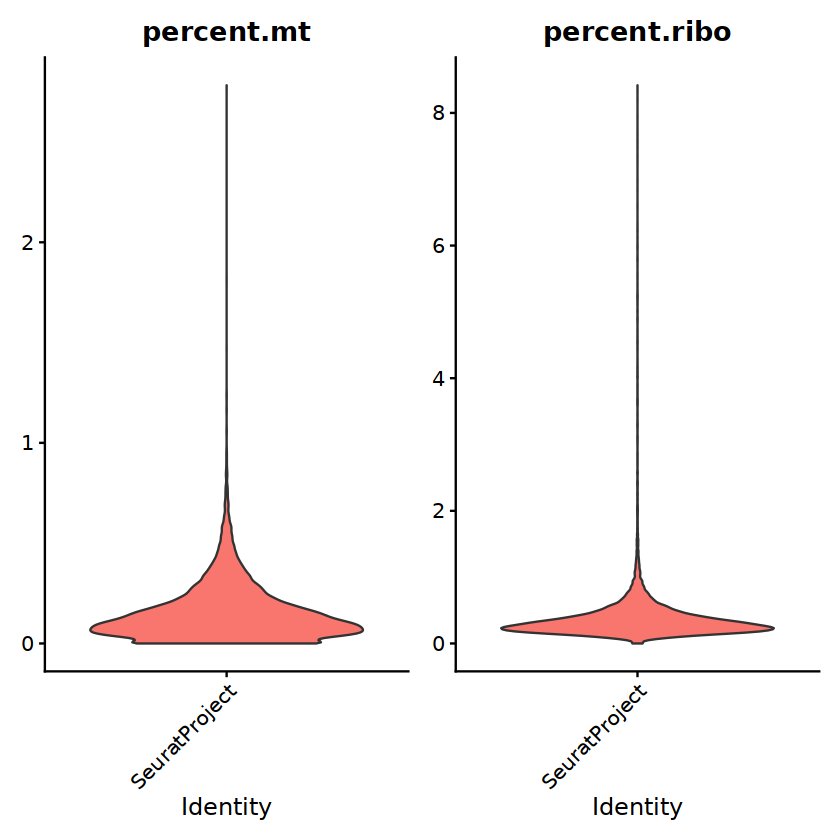

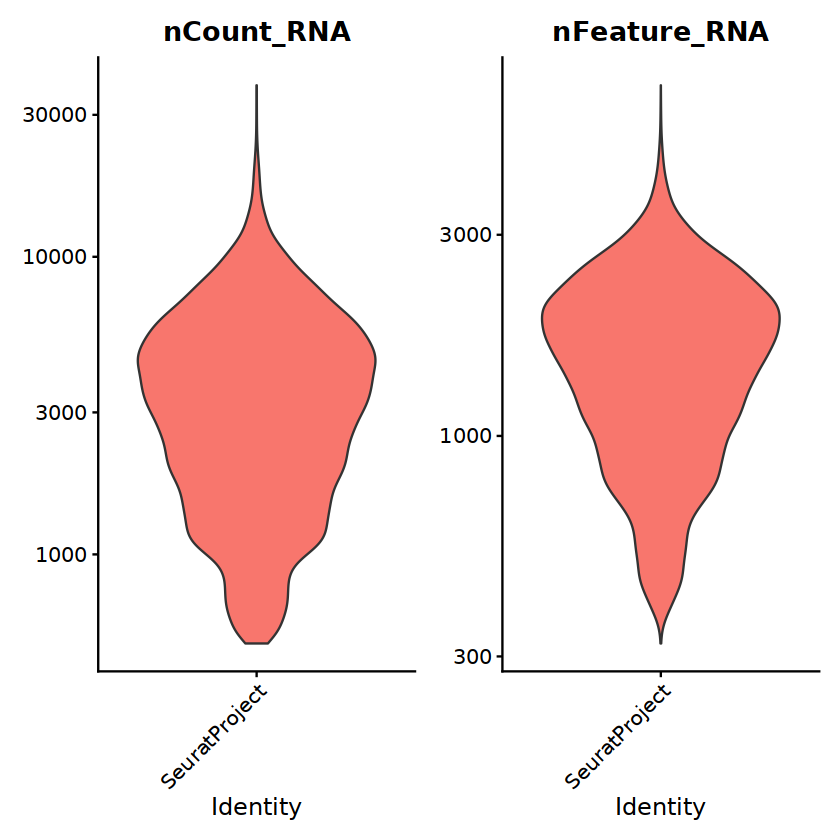

In [103]:
VlnPlot(mmg, features = c("percent.mt", "percent.ribo"), pt.size = 0)
VlnPlot(mmg, features = c("nCount_RNA", "nFeature_RNA"), log = T, pt.size = 0)

## Seurat clustering

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 24284
Number of edges: 773461

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8570
Number of communities: 26
Elapsed time: 4 seconds


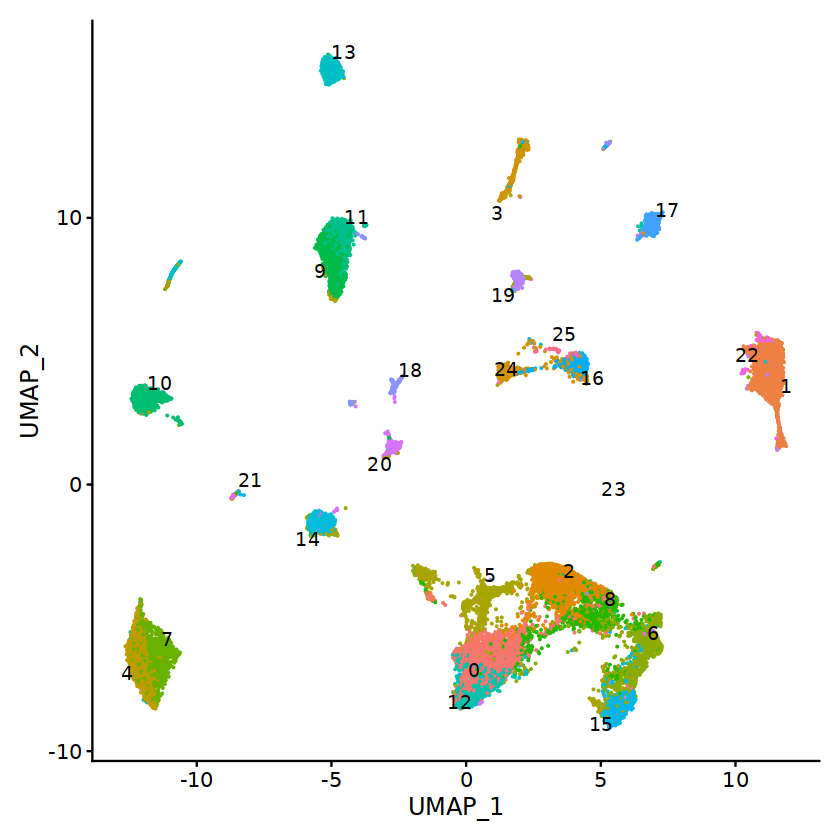

In [113]:
mmg <- RunRNA(mmg, var = "percent.mt", batch.label = "rna")
mmg <- FindNeighbors(object = mmg, k.param = 15, reduction = "harmony", verbose = F)
mmg <- FindClusters(object = mmg, resolution = 1.5)

DimPlot(mmg, label = T, repel = T) + NoLegend()

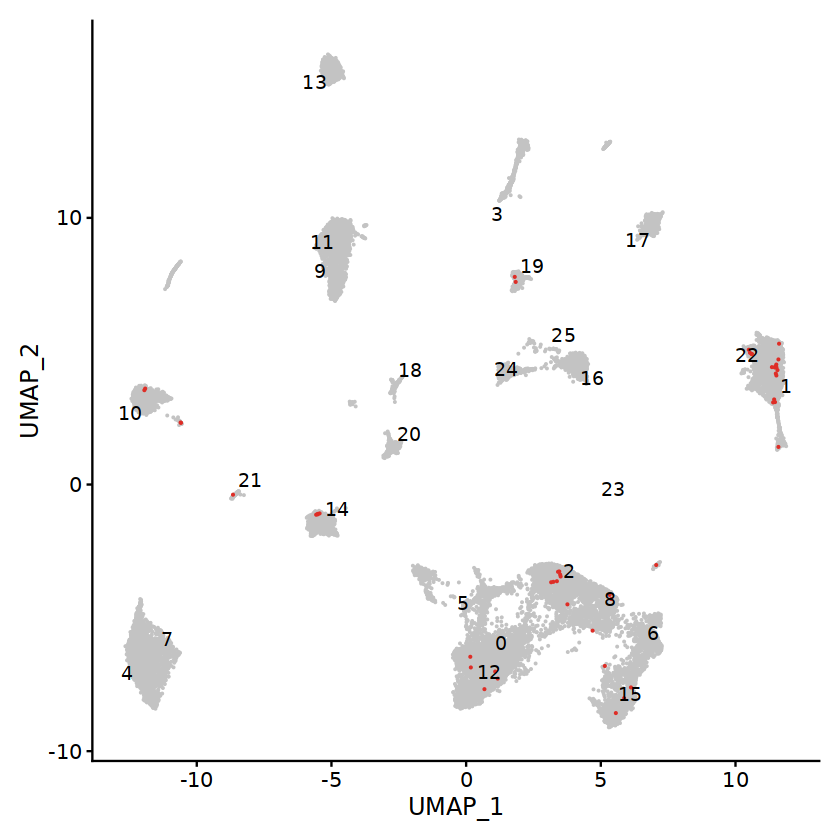

In [156]:
DimPlot(mmg, cells.highlight = rownames(mmg@meta.data[mmg$seurat_clusters == 23, ]), sizes.highlight = 0.1,
        label = T, repel = T) + NoLegend()

In [179]:
saveRDS(mmg, "seurat_object/FC_phc_RNA_rmDoublet_230728.rds")

In [65]:
### FindMarker 
Idents(mmg) <- "predicted.id"
marker <- FindAllMarkers(mmg, only.pos = T)
write.table(marker, "FC_phc_RNA_rmDoublet_240101_DPT_RNA_marker.txt", row.names = T, col.names = T, sep = "\t", quote = F)

Calculating cluster ITL23GL

Calculating cluster MGL

Calculating cluster CTGL

Calculating cluster OGC

Calculating cluster NPGL

Calculating cluster OBGA

Calculating cluster ITL45GL

Calculating cluster ITL6GL

Calculating cluster ITL5GL

Calculating cluster VIPGA

Calculating cluster D12MSN

Calculating cluster PTGL

Calculating cluster ASC

Calculating cluster CLAGL

Calculating cluster OPC

Calculating cluster SSTGA

Calculating cluster VLMC

Calculating cluster PVGA

Calculating cluster OBGL

Calculating cluster STRGA



Using avg.exp as value column: use value.var to override.



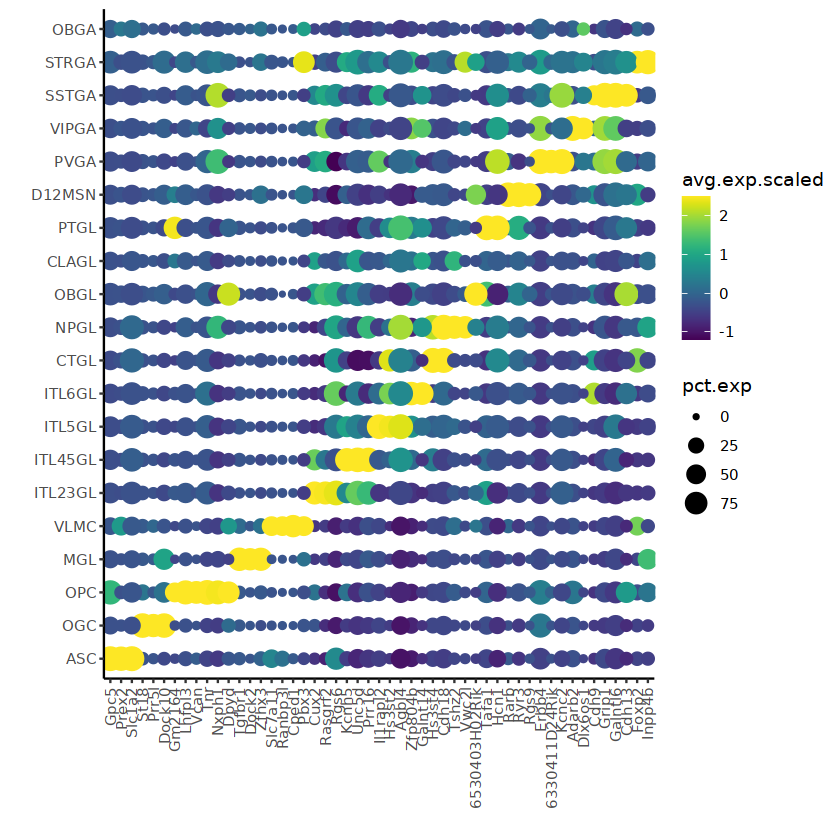

In [70]:
nmarker <- marker %>% dplyr::filter(p_val_adj < 0.05 & `pct.1` - `pct.2` > 0.2) %>% 
group_by(cluster) %>% slice_max(order_by = avg_log2FC, n = 3)
t1 <- DotPlot(mmg, group.by = "predicted.id", features = unique(nmarker$gene))

suppressPackageStartupMessages(library(viridis))
corder <- c("ASC", "OGC", "OPC", "MGL", "VLMC",
            "ITL23GL", "ITL45GL", "ITL5GL", "ITL6GL", "CTGL", "NPGL", "OBGL", "CLAGL", "PTGL",
            "D12MSN", "PVGA", "VIPGA", "SSTGA", "STRGA", "OBGA")
tmp <- t1$data
rmtx <- tmp[,c("features.plot", "id", "avg.exp")] %>%
reshape2::dcast(features.plot ~ id) %>%
tibble::column_to_rownames("features.plot")

max_indices <- max.col(rmtx[,corder])
permutation_vector <- order(max_indices)
smat <- rmtx[permutation_vector, corder]

t2 <- tmp %>% 
dplyr::filter(id != "Unknown") %>%
mutate(id = factor(id, levels = corder)) %>%
mutate(features.plot = factor(features.plot, levels = rownames(smat))) %>%
ggplot(aes(x = features.plot, y = id, size = pct.exp, color = avg.exp.scaled)) + 
geom_point() +
theme_classic() + xlab("") + ylab("") + 
scale_color_viridis() + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

t2

ggsave(t2, filename = "plot/FC_phc_RNA_rmDoublet_DPT_anno_240101_marker.pdf", dpi = 300, height = 8, width = 24)

In [80]:
mmarker <- read.csv("/projects/ps-renlab/y2xie/projects/scifi-multiome/28.FC_16k_Droplet_PT_221210/annotation/cemba_marker_genes_yel_SOM.csv")
mmarker <- mmarker %>%
dplyr::filter(Cell.subclasses %in% grep(paste(c(corder, "D1MSN", "D2MSN"), collapse = "|"), mmarker$Cell.subclasses, value = TRUE)) %>%
group_by(Cell.subclasses) %>% slice_sample(n = 2) %>% ungroup %>% dplyr::select("Marker") %>% unique
t1 <- DotPlot(mmg, group.by = "predicted.id", features = mmarker)

tmp <- t1$data
rmtx <- tmp[,c("features.plot", "id", "avg.exp")] %>%
reshape2::dcast(features.plot ~ id) %>%
tibble::column_to_rownames("features.plot")

max_indices <- max.col(rmtx[,corder])
permutation_vector <- order(max_indices)
smat <- rmtx[permutation_vector, corder]

t3 <- tmp %>% 
dplyr::filter(id != "Unknown") %>%
mutate(id = factor(id, levels = corder)) %>%
mutate(features.plot = factor(features.plot, levels = rownames(smat))) %>%
ggplot(aes(x = features.plot, y = id, size = pct.exp, color = avg.exp.scaled)) + 
geom_point() +
theme_classic() + xlab("") + ylab("") + 
scale_color_viridis() + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

ggsave(t3, filename = "plot/FC_phc_RNA_rmDoublet_DPT_anno_240101_marker_standard.pdf", dpi = 300, height = 8, width = 24)

Using avg.exp as value column: use value.var to override.



# Annotate via label transfer (Fig.6B)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



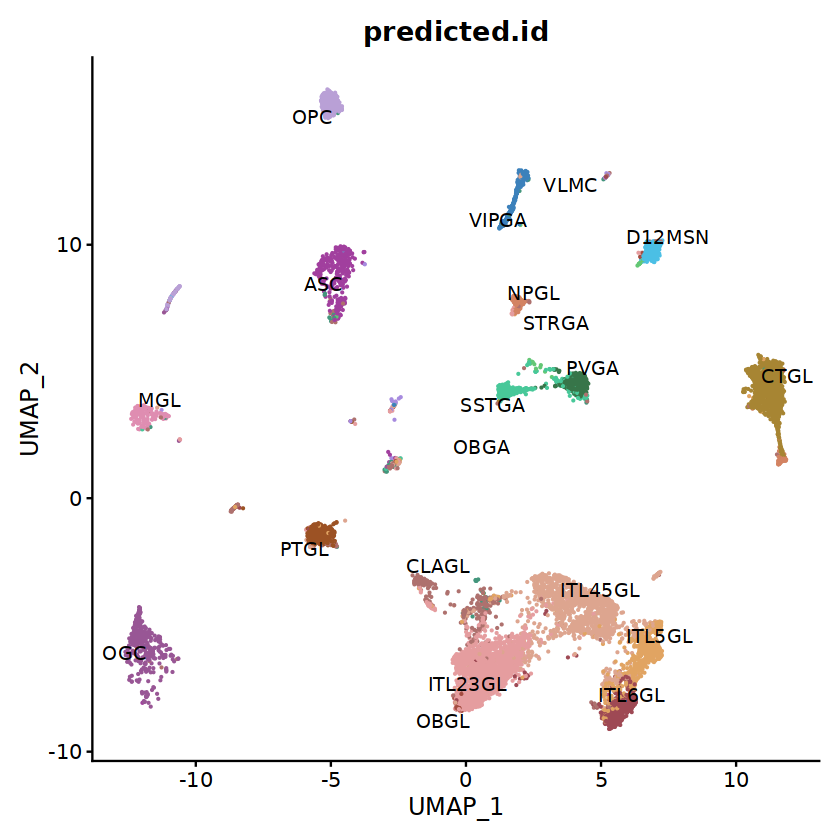

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



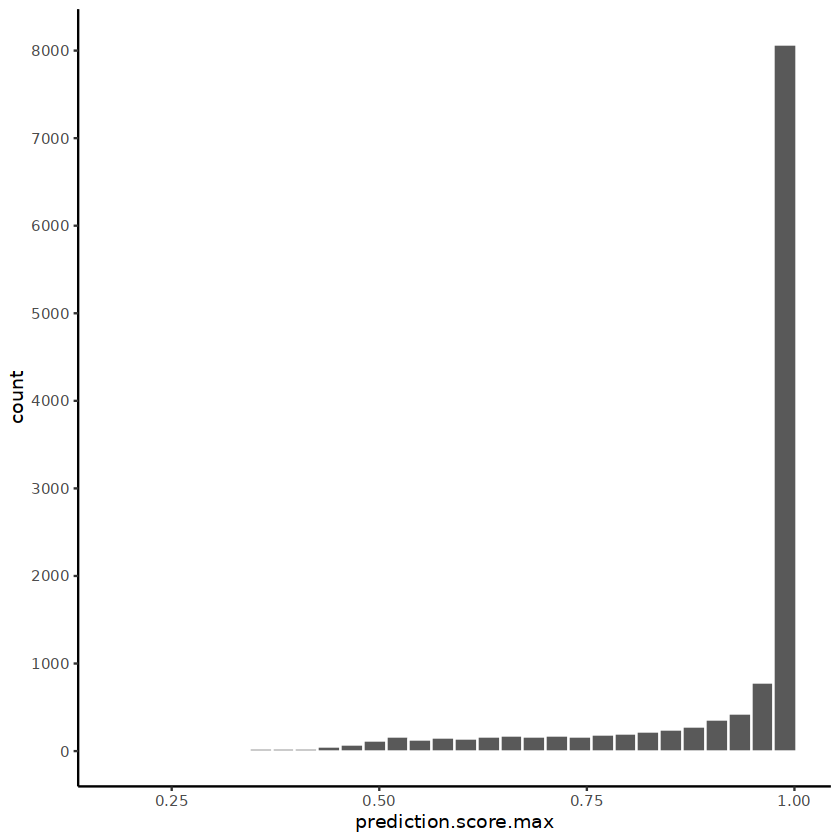

In [27]:
### read in reference:
mmg <- readRDS("seurat_object/FC_phc_RNA_rmDoublet_230728.rds")
DPT <- readRDS("/projects/ps-renlab/y2xie/projects/scifi-multiome/28.FC_16k_Droplet_PT_221210/05.R/seurat_object/FC_RNA_Seurat_merged_rmScrublet_221229.rds")
DPT <- subset(DPT, subset = RNA_keep_cells == "True")

### Run Integration
obj.anchors <- FindTransferAnchors(reference = DPT, query = mmg, 
                                   dims = 1:30, reference.reduction = "pca")
predictions <- TransferData(anchorset = obj.anchors, refdata = DPT$Anno0.8_yel, dims = 1:30)
mmg <- AddMetaData(mmg, metadata = predictions)
int.features <- SelectIntegrationFeatures(object.list = obj.list)
obj.anchors <- FindIntegrationAnchors(object.list = obj.list, anchor.features = int.features)
obj <- IntegrateData(anchorset = obj.anchors)
gc()

DefaultAssay(obj) <- "integrated"
obj <- ScaleData(obj, verbose = FALSE)
obj <- RunPCA(obj, npcs = 30, verbose = FALSE)
obj <- RunUMAP(obj, reduction = "pca", dims = 1:30)
obj <- FindNeighbors(obj, reduction = "pca", dims = 1:30)
obj <- FindClusters(obj, resolution = 0.5)
ccolor = distinct(DPT@meta.data[c("Anno0.8_yel", "Subclass.color")]) 
col1 <- ccolor$Subclass.color
names(col1) <- ccolor$Anno0.8_yel

### Plot only valid cells!!!
valid_cells <- mmg@meta.data[mmg$total > 15000, ] %>% rownames
t1 <- DimPlot(mmg, label = T, repel = T, group.by = 'predicted.id', cells = valid_cells) + 
NoLegend() + 
scale_color_manual(values = col1)

t2 <- mmg@meta.data[valid_cells,] %>%
ggplot(aes(x = prediction.score.max)) + 
geom_histogram(color = "white") + 
theme_classic() + scale_y_continuous(breaks = seq(0, length(valid_cells), 1000))

t1
t2

ggsave(t1, filename = "plot/phc_240101_DPT_annotation_prediction_UMAP.pdf", height = 6, width = 6, dpi = 300)
ggsave(t2, filename = "plot/phc_240101_DPT_annotation_prediction_score_dist.pdf", height = 6, width = 6, dpi = 300)
write.table(t2$data, "plot/phc_240101_DPT_annotation_prediction_score_dist.txt", sep = "\t", quote = F)
# saveRDS(mmg, paste0("seurat_object/FC_phc_240101_DPT_prediction.rds"))
# gc()

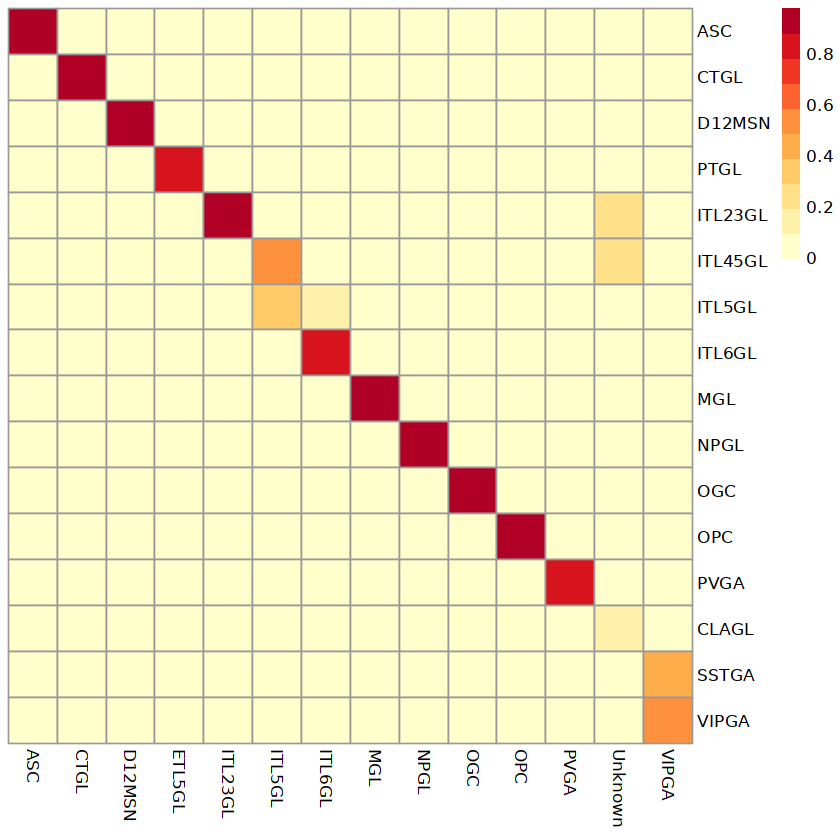

In [43]:
## Overlap of predicted results and self annotation
ovlp <- mmg@meta.data[valid_cells, c("predicted.id", "Anno_yel")] %>%
dplyr::filter(!(Anno_yel %in% c("CLAGL", "VEC", "PTGL"))) %>%
dplyr::filter(!(predicted.id %in% c("OBGA", "OBGL", "VLMC", "STRGA"))) %>%
table()

rmat <- t(t(ovlp) / colSums(ovlp))
max_indices <- max.col(rmat)
permutation_vector <- order(max_indices)
smat <- rmat[permutation_vector, ]

p1 <- smat %>%
pheatmap(cluster_rows = F, cluster_cols = F,
         color = colorRampPalette(brewer.pal(n = 8, name = "YlOrRd"))(10))
ggsave(p1, filename = "plot/FC_phc_RNA_rmDoublet_annot_clean_240101_DPT_annotate_overlap.pdf", dpi = 300, height = 8, width = 8)